<a href="https://colab.research.google.com/github/mswastik/forecasting/blob/main/SARIMAv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 808kB 17.0MB/s 
     |████████████████████████████████| 8.7MB 16.1MB/s 
     |████████████████████████████████| 2.1MB 46.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 50.3.0
    Uninstalling setuptools-50.3.0:
      Successfully uninstalled setuptools-50.3.0
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [2]:
import pmdarima as pmd
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf,adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
import plotly.express as px
import cufflinks as cf
import plotly.tools as tls

In [3]:
!git clone -l -s https://github.com/mswastik/forecasting.git cloned-repo
%cd cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 54 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (54/54), done.
/content/cloned-repo


In [8]:
warnings.filterwarnings("ignore")
df = pd.read_excel('Forecasting1.xlsx',sheet_name='SO',index_col='del date')
df.rename({'agg':'agg1'},axis=1,inplace=True)
df['dd']=df.index.copy()
df['month'] = df['dd'].dt.year.astype('str')+"-"+df['dd'].dt.month.astype('str')
df2=df.groupby(['month','agg1']).sum().copy()
df2.drop(['wt','cs size'],inplace=True,axis=1)
df['agg1'].unique()

array(['HRC tudi Yih', 'Tmmthpkhti Limi mm', 'Tmmthpkhti Limi Yih',
       'mdmdmh limi Yih', 'mdmdmh Lmtimm limi mm', 'mdmmil limi Yih',
       'dmuthwkhh limi mm', 'Tmmthpkhti Pmuch limi mm',
       'Tmmthpkhti Limi mm, htripi', 'Tmmthpmwdir limi Yih',
       'dlikch Limi Yih', 'Tmmthpkhti Limi mm, htripi trky',
       'Tmmthpkhti Limi yih, likglit', 'hkmigrihh limi mm', 'HRC tudi mm',
       'Tmmthpkhti Limi dihplkydmx', 'Tmmthpkhti Limi mm, trky',
       'Tmmthpkhti Limi dihplkydmx, htripi', 'Tmmthpkhti Limi yih',
       'Tmmthpkhti Limi Yih,kdditimmkl glkp im ckrtmm, Likglit',
       'Tmmthpkhti Limi Yih, tmmthdruhh', 'PJ Jkr mm',
       'Tmmthpkhti Limi Yih, htripi', 'HRC Tudi mm', 'HRC Tudi Yih',
       'Tmmthpkhti Limi yih, hmlmgrkd', 'Hkmdwkhh limi mm'], dtype=object)

In [28]:
toot=df.loc[df.agg1=='dlikch Limi Yih'].copy()
toot=pd.DataFrame(toot['cases'])
toot=toot.resample('M').sum()

In [29]:
px.line(toot,y='cases',x=toot.index)

In [27]:
px.box(toot,y='cases')

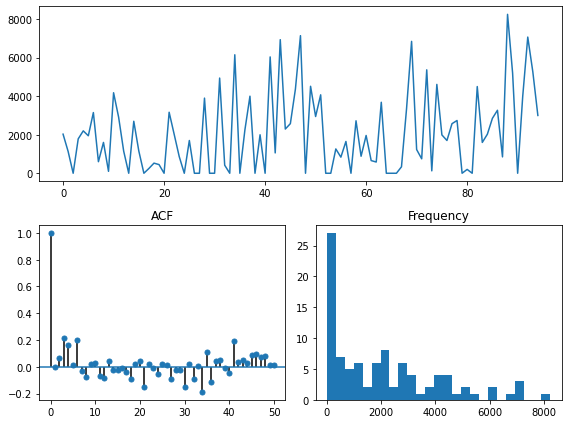

In [12]:
from pmdarima.utils import tsdisplay
tsdisplay(toot)

In [13]:
toot=toot.loc[toot.cases<=8000]

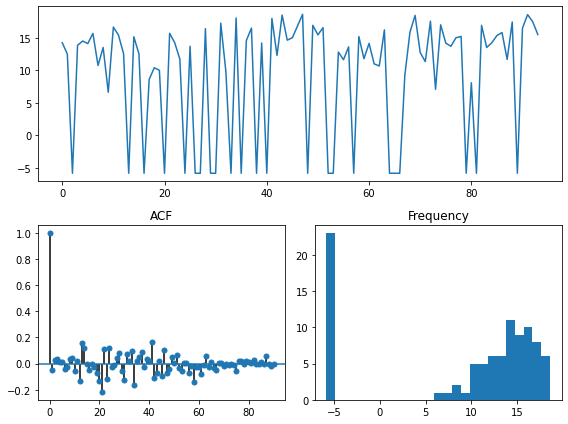

In [16]:
from pmdarima.preprocessing import BoxCoxEndogTransformer
y_train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(toot)
tsdisplay(y_train_bc, lag_max=90)

In [22]:
#plt.figure(figsize=(15,10))
#from plotly.plotly import plot_mpl
hh=seasonal_decompose(x=toot,model='additive',freq=12).plot()
hh.set_size_inches(15,13)
tls.mpl_to_plotly(hh)

In [23]:
model1 = pmd.auto_arima(toot,seasonal=True,m=12)
pred,ci=model1.predict_in_sample(toot[0:94],return_conf_int=True)
pred1,ci1=model1.predict(10,return_conf_int=True)

In [24]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   94
Model:                        SARIMAX   Log Likelihood                -846.786
Date:                Sat, 24 Oct 2020   AIC                           1697.573
Time:                        11:11:52   BIC                           1702.659
Sample:                             0   HQIC                          1699.627
                                 - 94                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1987.8511    268.200      7.412      0.000    1462.188    2513.514
sigma2      3.909e+06   7.59e+05      5.153      0.000    2.42e+06     5.4e+06
===================================================================================
Ljung-Box (Q):                       37.05   Jarque-Bera (JB):                12.93
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               2.23   Skew:                             0.91
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
from pmdarima.metrics import smape
smape(toot, pred)

97.69566400606723

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(toot, pred)

181756195.59859794

In [ ]:
import plotly.graph_objects as go
fig=px.line(data_frame=toot,x=toot.index,y='cases')
fig.add_scatter(x=toot.index,y=pred,name='pred')
fig.add_scatter(x=pd.date_range(toot.index[94], periods=10,freq='M'),y=pred1,name='pred1')
fig.add_scatter(x=toot.index,y=ci[:,0])
fig.add_scatter(x=toot.index,y=ci[:,1],fill='tonexty')
fig.add_scatter(x=pd.date_range(toot.index[94], periods=10,freq='M'),y=ci1[:,0])
fig.add_scatter(x=pd.date_range(toot.index[94], periods=10,freq='M'),y=ci1[:,1],fill='tonexty')

In [ ]:
from pmdarima.arima import ndiffs
ndiffs(toot, alpha=0.05, test='kpss', max_d=6)

1

In [ ]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(toot)

Results of Dickey-Fuller Test:
Test Statistic                 -1.755483
p-value                         0.402776
#Lags Used                      6.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [ ]:
n_train = 24
n_records = len(toot)
fore = {}
res=[]
for i in range(n_train, n_records):
    pre=[]
    train, test = toot[0:i].copy(), toot[i:i+1].copy()
    mod = SARIMAX(train, order=(0, 1, 1), seasonal_order=(2, 0, 0, 12))
    mod=mod.fit()
    fore.update(mod.forecast(1))
    pre = mod.forecast()
    res.extend(rmse(test,pre))
#df1.plot(legend=True,figsize=(15,10))
#pre.plot(legend=True)

In [ ]:
print("Avg rmse is %d" %np.mean(res))

Avg rmse is 12991


In [ ]:
mod1 = SARIMAX(toot, order=(0, 1, 1), seasonal_order=(2, 0, 0, 3))
mod1 = mod1.fit()

In [ ]:
predict=mod1.get_prediction(12)
pred=predict.conf_int()
pred

,lower cases,upper cases
del date,,
2013-11-30,-44190.426570,35343.551762
2013-12-31,-37014.820467,42142.854471
2014-01-31,-37630.434059,41217.754926
2014-02-28,-39426.864793,39162.532923
2014-03-31,-41542.946418,36827.033017
...,...,...
2020-07-31,-50982.086899,25366.755939
2020-08-31,-36568.760639,39778.403034
2020-09-30,-37472.154512,38873.405084


In [ ]:
import plotly.graph_objects as go
fig=px.line(data_frame=toot,x=toot.index,y='cases',labels="Actual")
fig.add_scatter(x=pred.index,y=pred['lower cases'])
fig.add_scatter(x=pred.index,y=pred['upper cases'],fill='tonexty')
fig.add_scatter(x=toot.index,y=toot['cases'])
#fig2=px.area(cint)
#fig.add_trace()

In [ ]:
fig2=px.area(cint,x=cint.index,y='lower y')
fig2.add_scatter(x=cint.index,y=cint['upper y'])

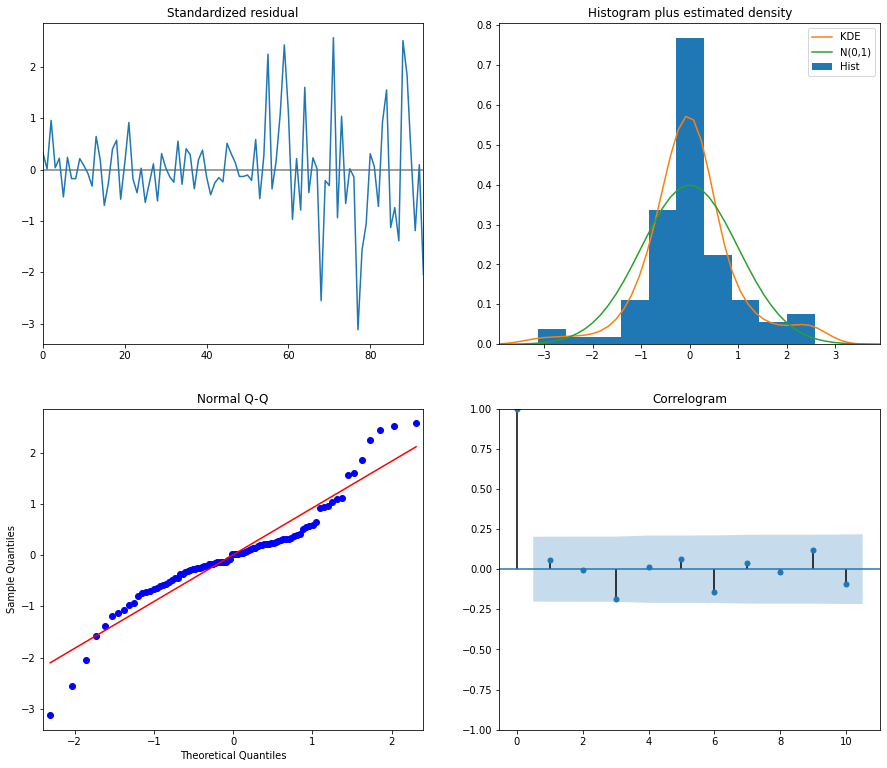

In [ ]:
kk=mod1.plot_diagnostics()
kk.set_size_inches(15,13)
#tls.mpl_to_plotly(kk)

In [ ]:
mod.get_forecast(6).conf_int()

,lower cases,upper cases
93,-15699.988162,41292.435638
94,-46756.966589,16665.465272
95,-29071.925267,34350.506594
96,-33558.716445,32006.382284
97,-21968.040161,44097.556789
98,-33953.215027,32112.381924
